 <div style="text-align:center; color:red; font-size:40px;">Customer Churn Prediction</div>

<div style="text-align: center;">
    <img src="Customer Churn image.png" alt="Example Image" 
         style="width:600px;height:400px;">
</div>


# What is the Customer Churn:

**Customer churn**, also known as customer attrition, refers to the rate at which customers stop doing business with a company over a given period.
 It is a key metric for businesses, especially in subscription-based models, telecommunications, banking, e-commerce, and SaaS (Software as a Service) industries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

In [3]:
data=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df0=data.copy()
df0.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:

print(f'the Shape of Data: {df0.shape}')
   

the Shape of Data: (7043, 21)


In [5]:
df0.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [6]:
for col in df0.columns:
    print(f'the  values of {col}:{df0[col].unique().tolist()}')
    print('******************************************************************')

the  values of customerID:['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', '7795-CFOCW', '9237-HQITU', '9305-CDSKC', '1452-KIOVK', '6713-OKOMC', '7892-POOKP', '6388-TABGU', '9763-GRSKD', '7469-LKBCI', '8091-TTVAX', '0280-XJGEX', '5129-JLPIS', '3655-SNQYZ', '8191-XWSZG', '9959-WOFKT', '4190-MFLUW', '4183-MYFRB', '8779-QRDMV', '1680-VDCWW', '1066-JKSGK', '3638-WEABW', '6322-HRPFA', '6865-JZNKO', '6467-CHFZW', '8665-UTDHZ', '5248-YGIJN', '8773-HHUOZ', '3841-NFECX', '4929-XIHVW', '6827-IEAUQ', '7310-EGVHZ', '3413-BMNZE', '6234-RAAPL', '6047-YHPVI', '6572-ADKRS', '5380-WJKOV', '8168-UQWWF', '8865-TNMNX', '9489-DEDVP', '9867-JCZSP', '4671-VJLCL', '4080-IIARD', '3714-NTNFO', '5948-UJZLF', '7760-OYPDY', '7639-LIAYI', '2954-PIBKO', '8012-SOUDQ', '9420-LOJKX', '6575-SUVOI', '7495-OOKFY', '4667-QONEA', '1658-BYGOY', '8769-KKTPH', '5067-XJQFU', '3957-SQXML', '5954-BDFSG', '0434-CSFON', '1215-FIGMP', '0526-SXDJP', '0557-ASKVU', '5698-BQJOH', '5122-CYFXA', '8627-ZYGSZ', '3410-YOQBQ', '3170-NMYVV', '7410-O

In [7]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
df0.duplicated().sum()


np.int64(0)

In [9]:
df0.drop(columns=['customerID'],inplace=True)
df0['TotalCharges']=pd.to_numeric(df0['TotalCharges'],errors='coerce')



In [10]:
df0.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [11]:
for col in df0.columns:
    print(f'{col}: {df0[col].value_counts()}')
    print('*********************************************************')

gender: gender
Male      3555
Female    3488
Name: count, dtype: int64
*********************************************************
SeniorCitizen: SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64
*********************************************************
Partner: Partner
No     3641
Yes    3402
Name: count, dtype: int64
*********************************************************
Dependents: Dependents
No     4933
Yes    2110
Name: count, dtype: int64
*********************************************************
tenure: tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64
*********************************************************
PhoneService: PhoneService
Yes    6361
No      682
Name: count, dtype: int64
*********************************************************
MultipleLines: MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: in

In [12]:
df0.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [13]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


# EDA

In [14]:
df1=df0.copy()

In [15]:
numcol=[col for col in df1.select_dtypes(include=[float,int]).columns if col!= 'SeniorCitizen']
for col in numcol:
    print(f'The skewness of {col}:{df1[col].skew()}')
    print('******************************************************')

The skewness of tenure:0.2395397495619829
******************************************************
The skewness of MonthlyCharges:-0.22052443394398033
******************************************************
The skewness of TotalCharges:0.961642499724251
******************************************************


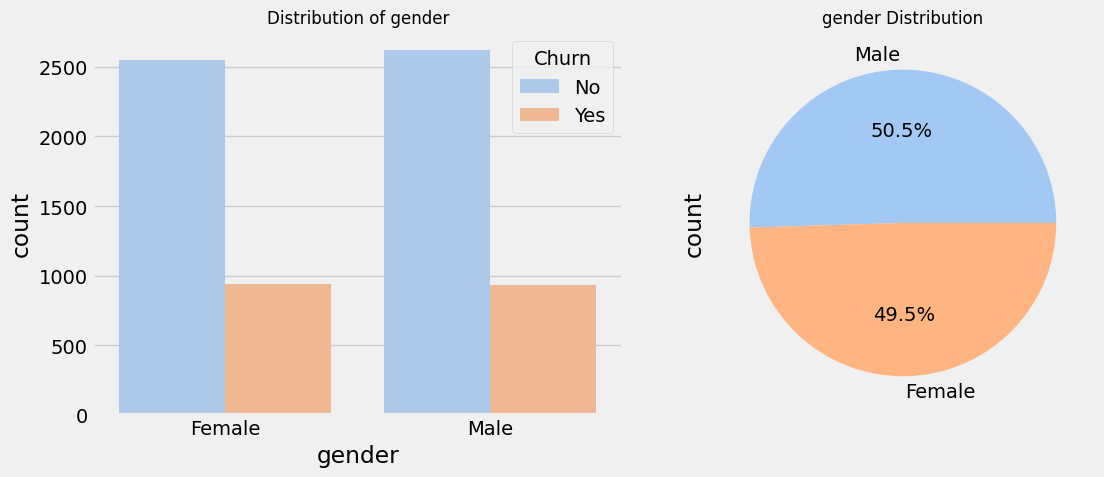

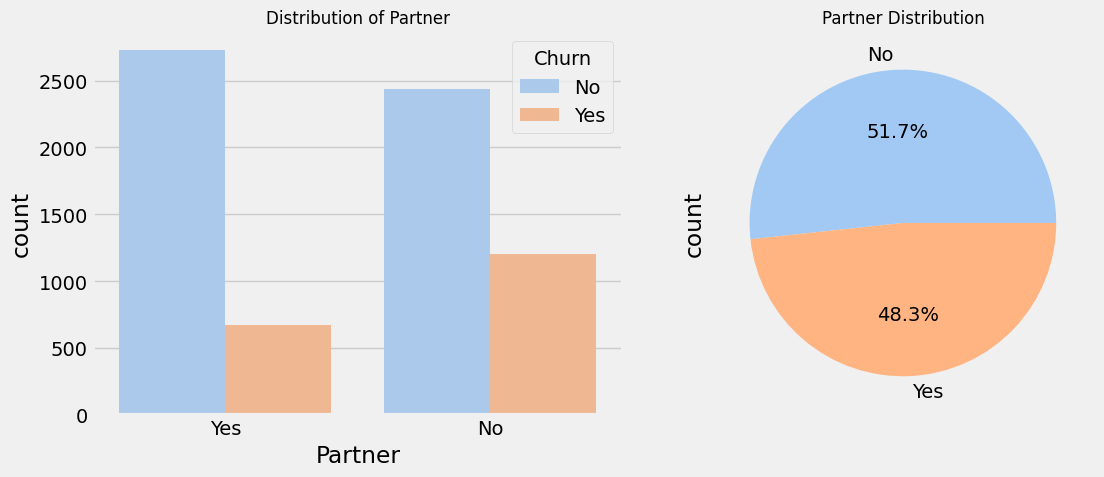

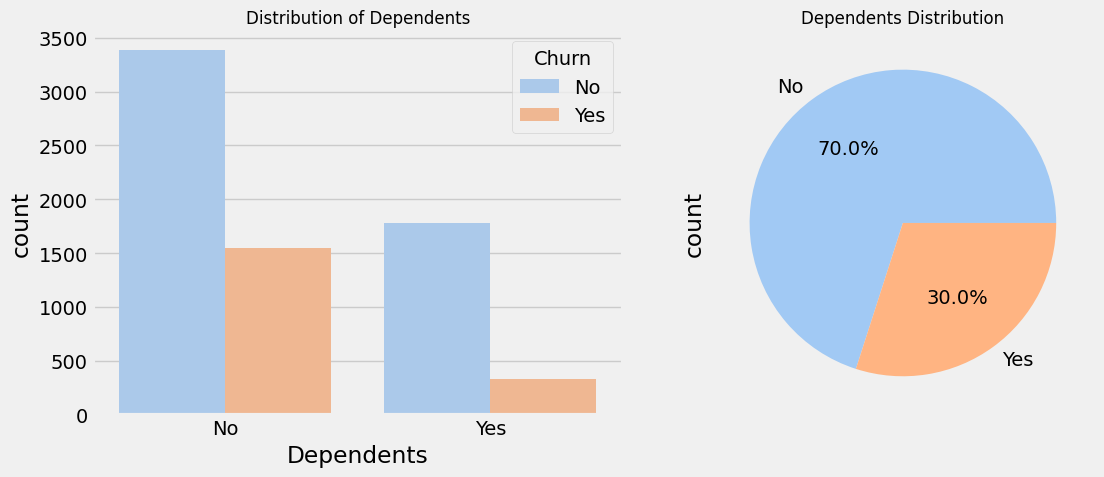

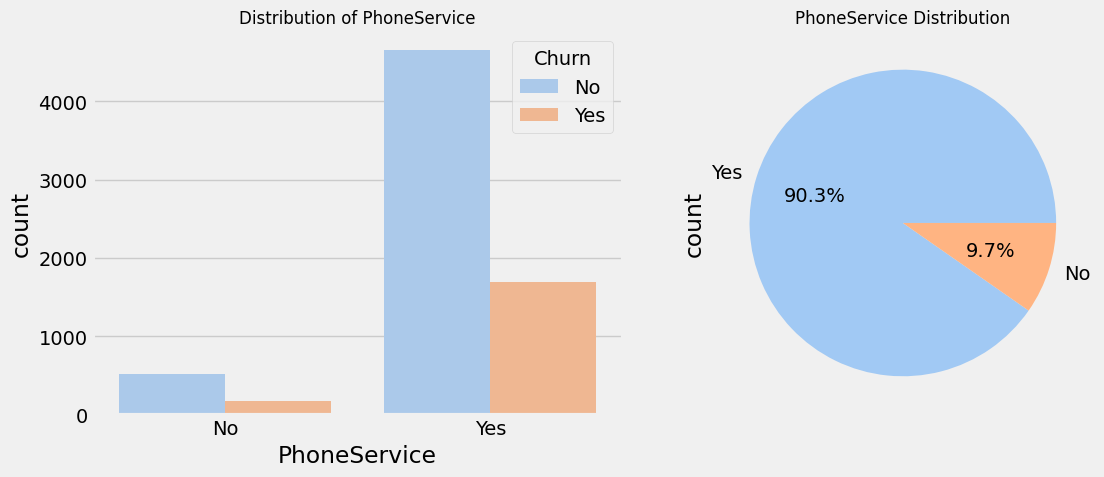

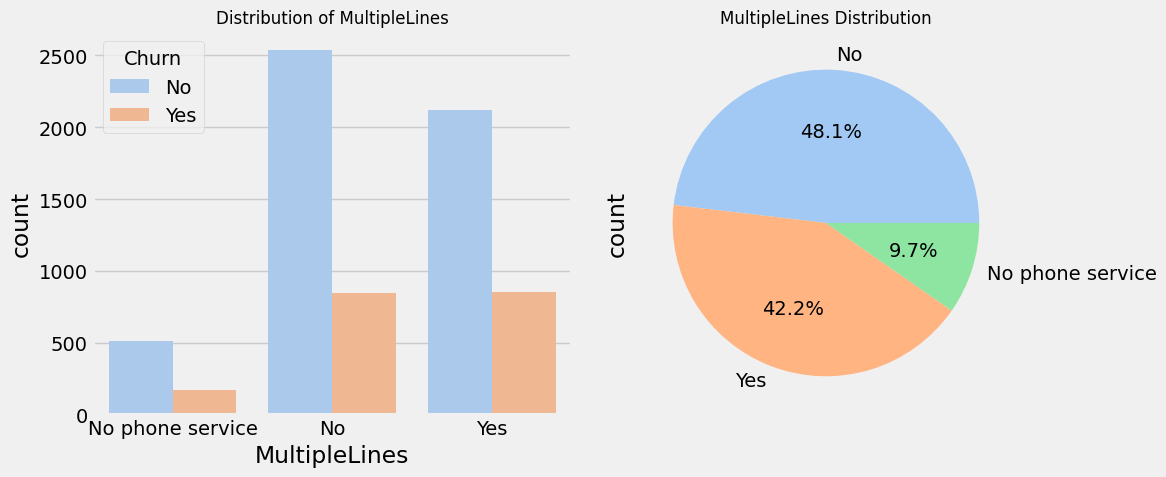

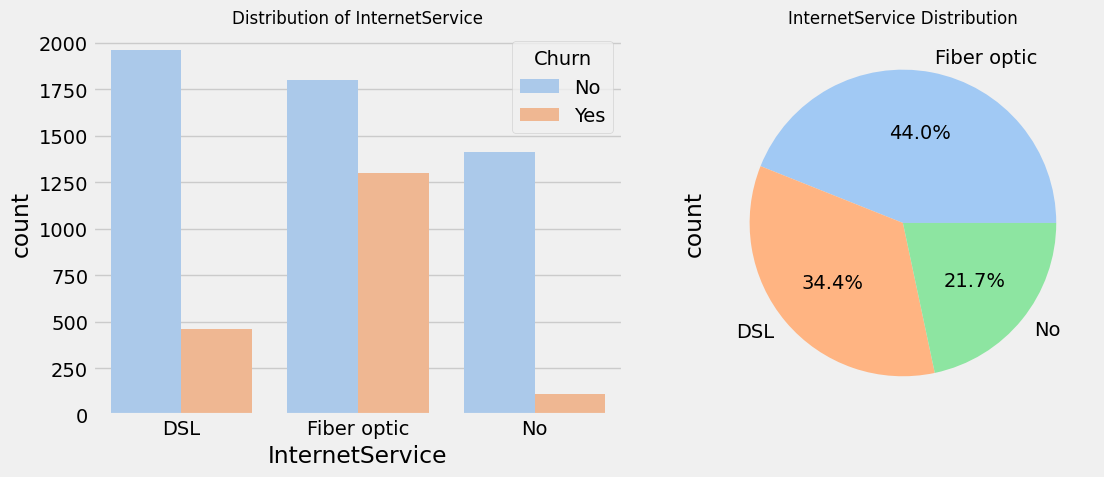

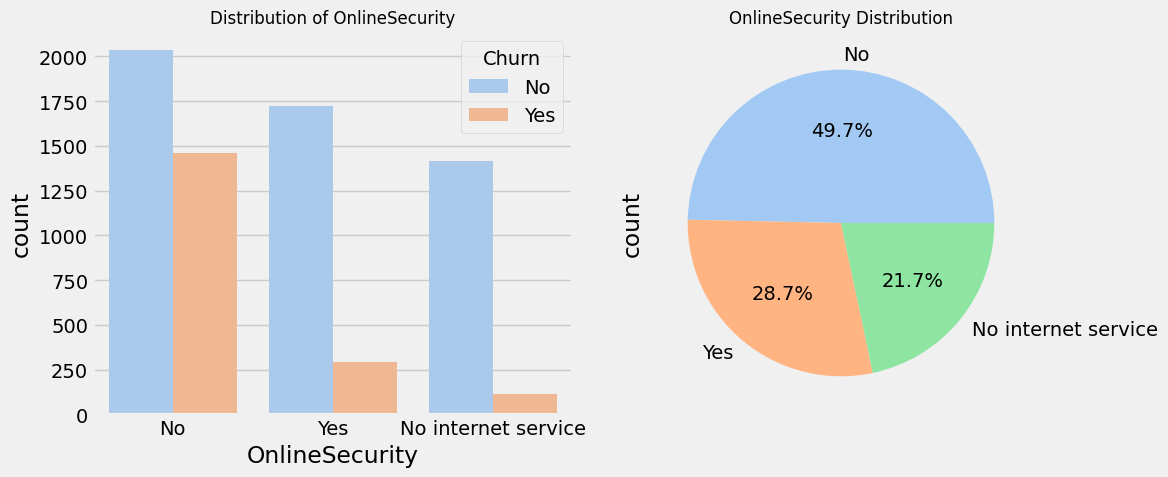

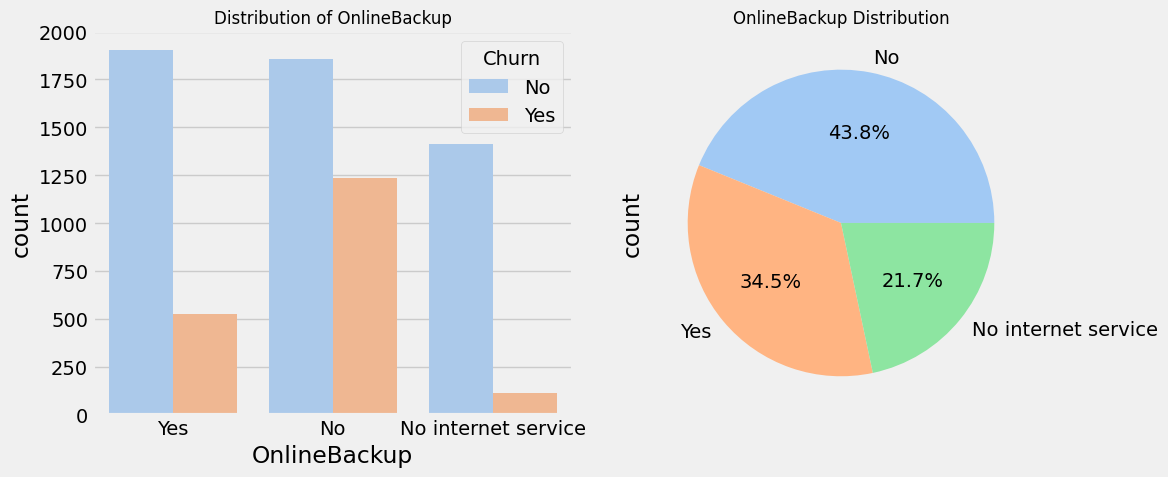

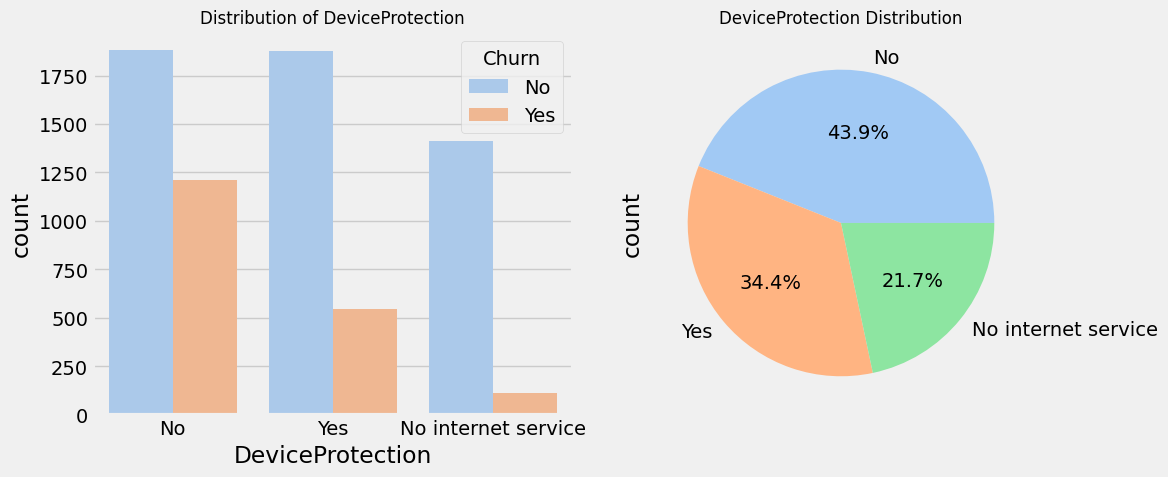

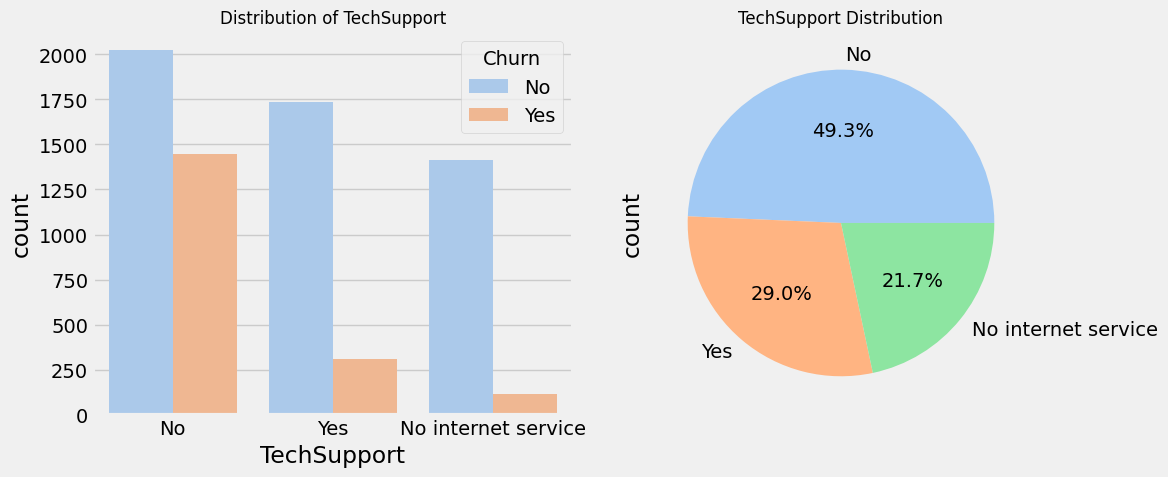

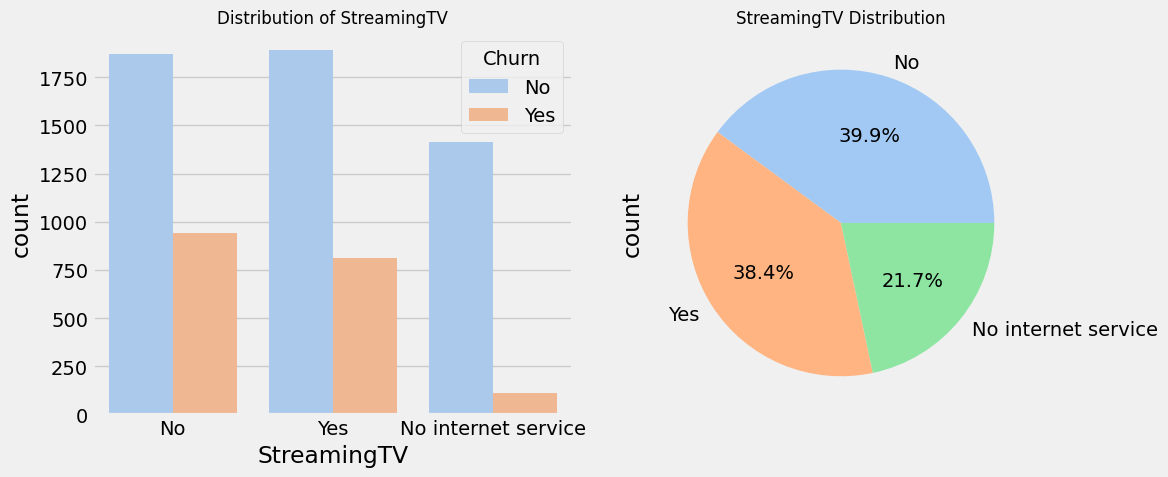

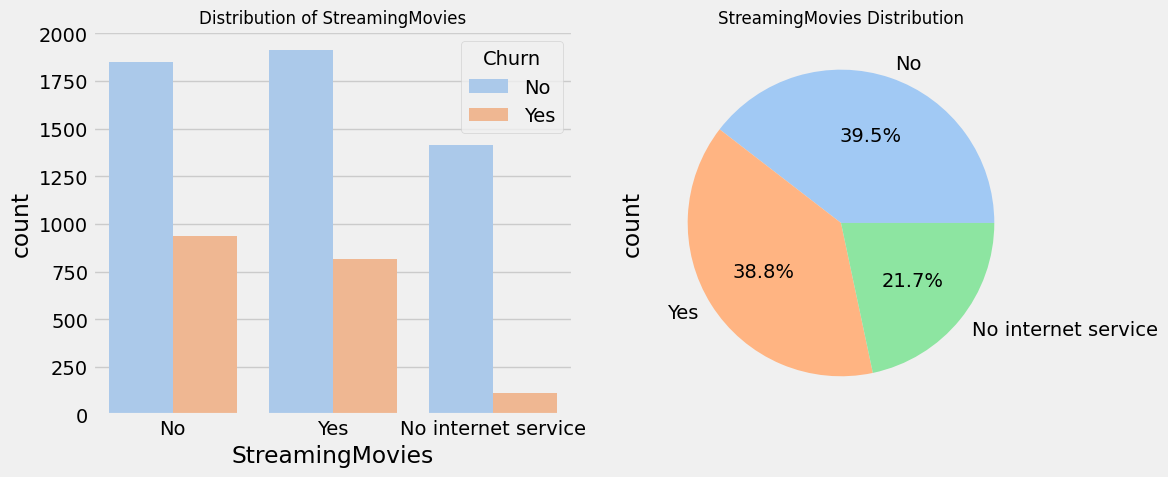

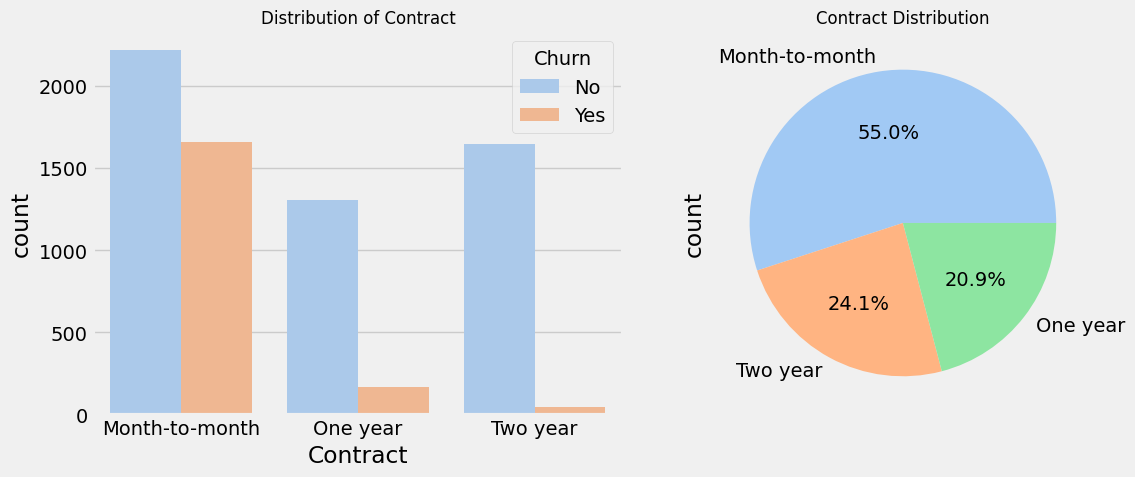

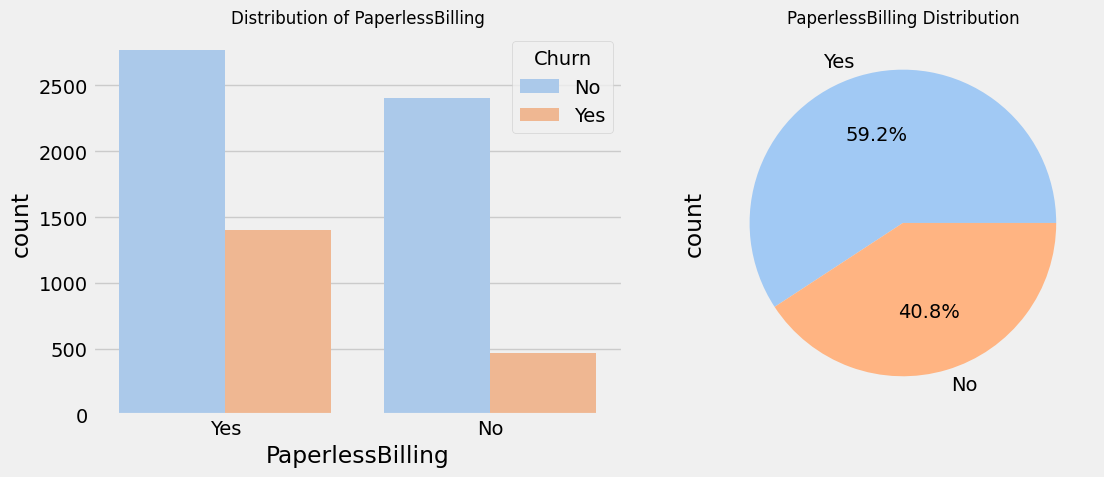

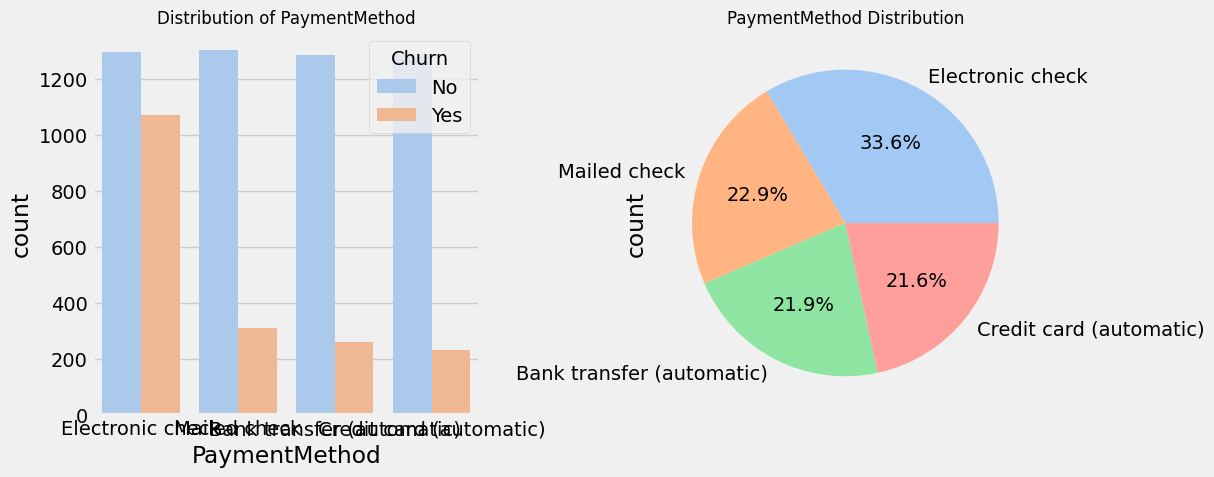

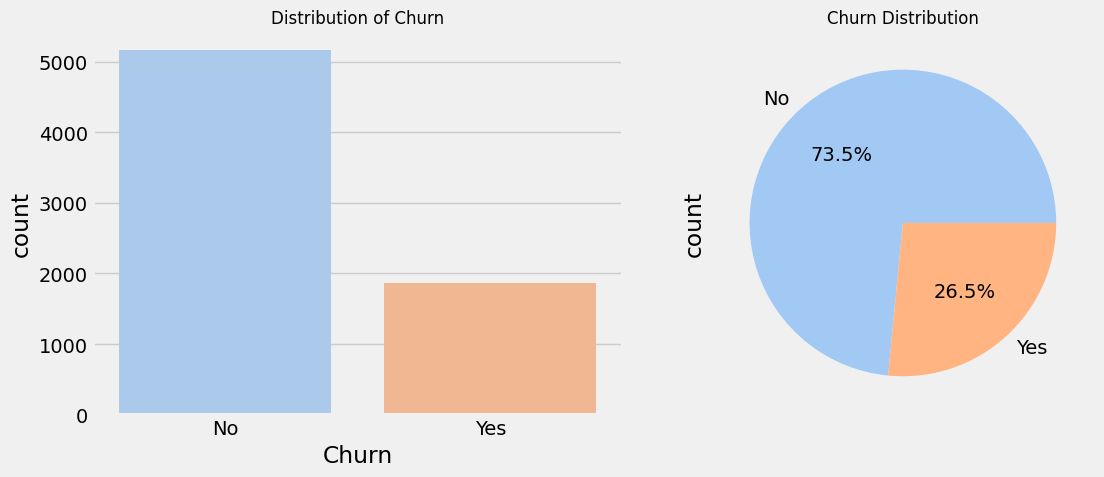

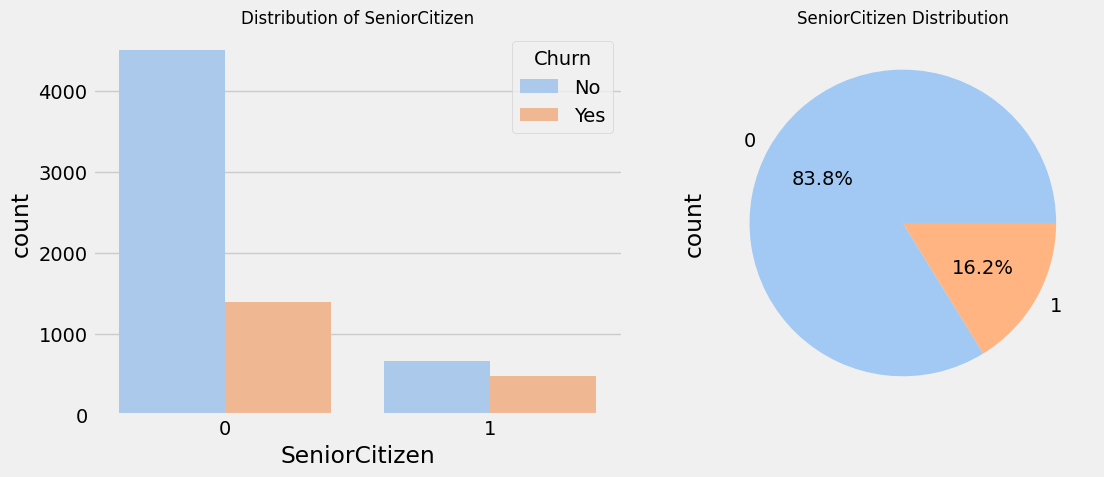

In [16]:
# Univariate Analysis:
## Categorical
catcol=df1.select_dtypes(include=object).columns.tolist() + ['SeniorCitizen']
sns.set_palette('pastel')
for col in catcol:
    plt.figure(figsize=(12, 5))

    plt.subplot(1,2,1)
    sns.countplot(data=df1,x=df1[col],hue='Churn')
    plt.title(f'Distribution of {col}',fontsize=12)
    
    plt.subplot(1,2,2)
    df1[col].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title(f'{col} Distribution',fontsize=12)

    plt.tight_layout()
    plt.show()

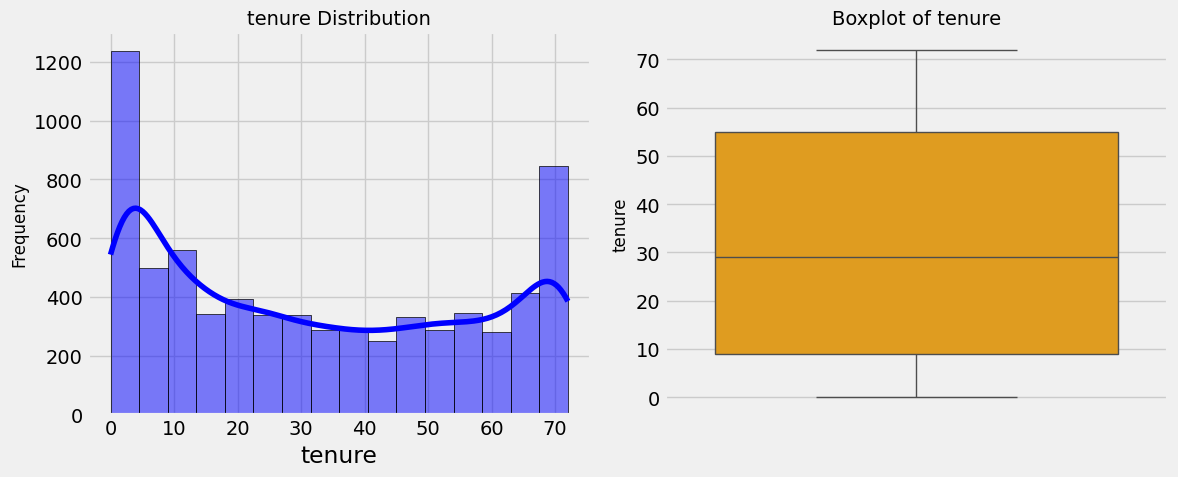

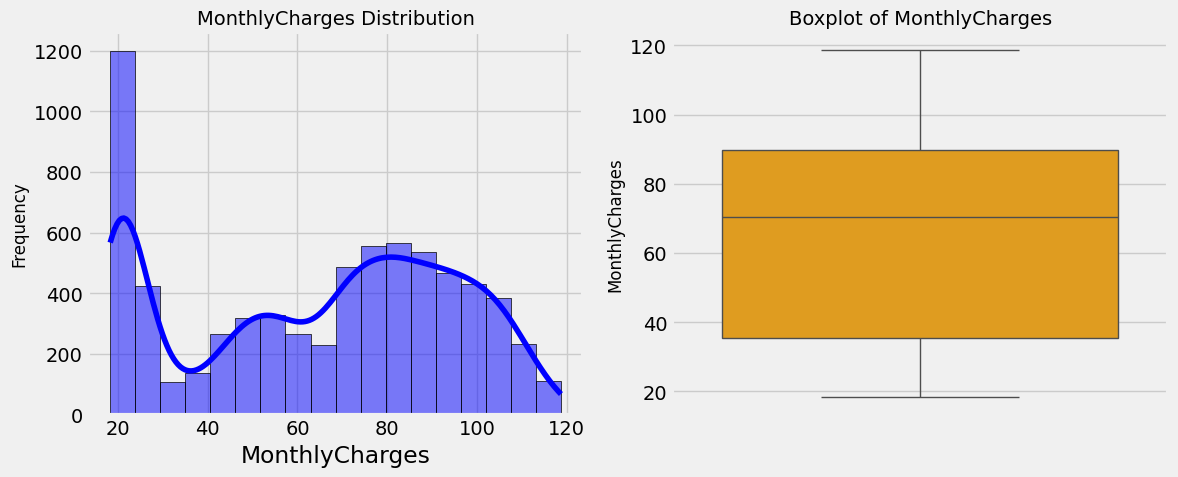

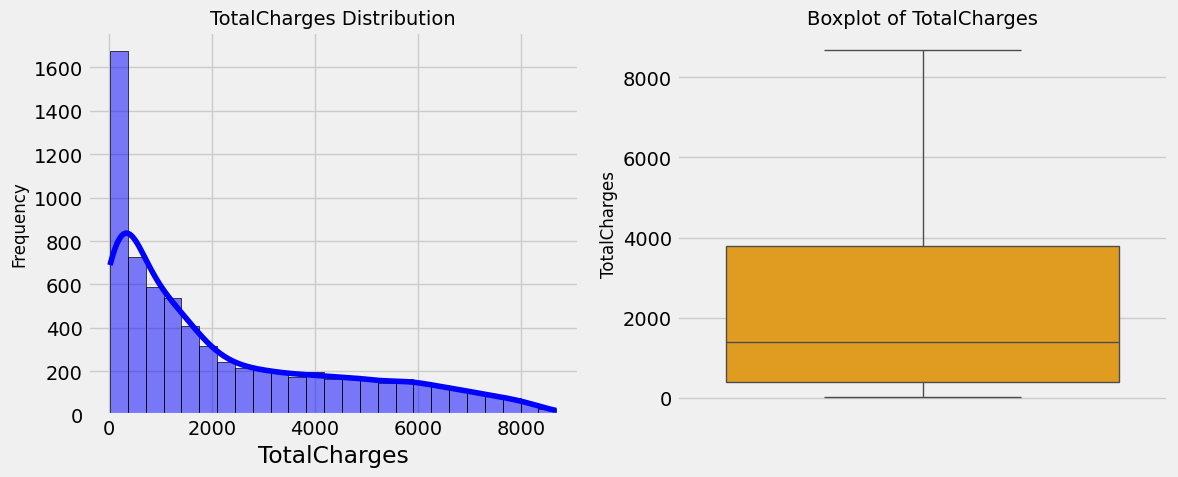

In [17]:
# Numerical Distribution:
for col in numcol:
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.histplot(data=df1,x=df1[col], kde=True,color='blue' , edgecolor='black')
    plt.title(f'{col} Distribution',fontsize=14)
    plt.ylabel(f'Frequency',fontsize=12)

    
    # Second subplot: Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df1[col], color='orange')
    plt.title(f"Boxplot of {col}", fontsize=14)
    plt.ylabel(col, fontsize=12)

    plt.tight_layout()
    plt.show()

# Building Models

In [18]:
df2=df1.copy()
df2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [19]:
from sklearn.model_selection import train_test_split,GridSearchCV,KFold 
from sklearn.preprocessing import StandardScaler,LabelEncoder
from imblearn.over_sampling import SMOTE

In [20]:
# Encoding the dependent Feature:
df2['Churn'].replace({'Yes':1,'No':0},inplace=True)
df2['Churn']

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64

In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [22]:
numerical_col=['tenure', 'MonthlyCharges','TotalCharges']
categorical_col=df2.select_dtypes(include=object).columns.tolist()

#Encode Numerical data using StandardScaler
standard={}
for col in numerical_col:
    stsc=StandardScaler()
    df2[col]=stsc.fit_transform(df2[[col]])
    standard[col]=stsc


# Encode Categorical data using LabelEncoder:

encoders={}
for col in categorical_col:
    labelencoder=LabelEncoder()
    df2[col]=labelencoder.fit_transform(df2[col])
    encoders[col]=labelencoder




In [23]:
standard

{'tenure': StandardScaler(),
 'MonthlyCharges': StandardScaler(),
 'TotalCharges': StandardScaler()}

In [24]:
encoders

{'gender': LabelEncoder(),
 'Partner': LabelEncoder(),
 'Dependents': LabelEncoder(),
 'PhoneService': LabelEncoder(),
 'MultipleLines': LabelEncoder(),
 'InternetService': LabelEncoder(),
 'OnlineSecurity': LabelEncoder(),
 'OnlineBackup': LabelEncoder(),
 'DeviceProtection': LabelEncoder(),
 'TechSupport': LabelEncoder(),
 'StreamingTV': LabelEncoder(),
 'StreamingMovies': LabelEncoder(),
 'Contract': LabelEncoder(),
 'PaperlessBilling': LabelEncoder(),
 'PaymentMethod': LabelEncoder()}

In [25]:
import pickle
with open('encoder.pkl','wb') as f:
    pickle.dump(encoders,f)

with open('scaler.pkl','wb') as f:
    pickle.dump(standard,f)

In [26]:
df2.dropna(inplace=True)
df2.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [27]:
# Define the output and the inputs
X=df2.iloc[:,:-1]
y=df2['Churn']

#  Split the data set 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
X.isna().sum()


gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [28]:
# Check if the output is imbalanced

max_count= y_train.value_counts().max()
min_count= y_train.value_counts().min()
IR=max_count /min_count
IR
# the output is imbalanced

np.float64(2.762541806020067)

In [29]:
# Resampling the output
from imblearn.over_sampling import SMOTE
smote=SMOTE(random_state=42)
X_train_smote,y_train_smote=smote.fit_resample(X_train,y_train)

y_train_smote.value_counts()

Churn
1    4130
0    4130
Name: count, dtype: int64

In [30]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [31]:
models={
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}
Hyperparmeter={
    'Random Forest':{'n_estimators':[50,100,200],
                     'max_depth':[3,5,7],
    },
    'XGBoost':{'learning_rate':[0.01,0.1,0.2],
               'max_depth':[3,5,7],

    }

}

In [32]:
cv1=KFold(n_splits=5,shuffle=True,random_state=42)
best_models={}
for model_name,model in models.items():
    print(f"Tunning {model_name}..............")
    grid=GridSearchCV(estimator=model,param_grid=Hyperparmeter[model_name],cv=cv1,scoring='accuracy')
    grid.fit(X_train_smote,y_train_smote)
    best_models[model_name]=grid.best_estimator_
    print(f"Best parameters for {model_name}:{grid.best_params_}")
    print(f"The best Accuracy for {model_name}: {grid.best_score_: .2f}\n")









Tunning Random Forest..............
Best parameters for Random Forest:{'max_depth': 7, 'n_estimators': 100}
The best Accuracy for Random Forest:  0.80

Tunning XGBoost..............
Best parameters for XGBoost:{'learning_rate': 0.1, 'max_depth': 7}
The best Accuracy for XGBoost:  0.83



In [33]:
from sklearn.metrics import confusion_matrix,roc_auc_score, classification_report,accuracy_score
y_train_pred= best_models['Random Forest'].predict(X_train_smote)
y_test_pred=best_models['Random Forest'].predict(X_test)

In [34]:
print(f" The Accuracy of Train data: {accuracy_score(y_train_pred,y_train_smote)}\n The Accuracy of Test data: {accuracy_score(y_test_pred,y_test)}")
print('***************************************************************************************************************************************')
print(f"The confusion matrix of train data:\n {confusion_matrix(y_train_pred,y_train_smote)}\n The confusion matrix of test data\n {confusion_matrix(y_test_pred,y_test)}")
print('***************************************************************************************************************************************')
print(f"the classification report of Train data:\n {classification_report(y_test_pred,y_test)}")
print('***************************************************************************************************************************************')
print(f"The ROC-AUC of train data:\n {roc_auc_score(y_train_pred,y_train_smote)}\n The ROC-AUC of test data:\n {roc_auc_score(y_test_pred,y_test)}")

 The Accuracy of Train data: 0.823002421307506
 The Accuracy of Test data: 0.7341862117981521
***************************************************************************************************************************************
The confusion matrix of train data:
 [[3204  536]
 [ 926 3594]]
 The confusion matrix of test data
 [[753  94]
 [280 280]]
***************************************************************************************************************************************
the classification report of Train data:
               precision    recall  f1-score   support

           0       0.73      0.89      0.80       847
           1       0.75      0.50      0.60       560

    accuracy                           0.73      1407
   macro avg       0.74      0.69      0.70      1407
weighted avg       0.74      0.73      0.72      1407

***************************************************************************************************************************************
The RO

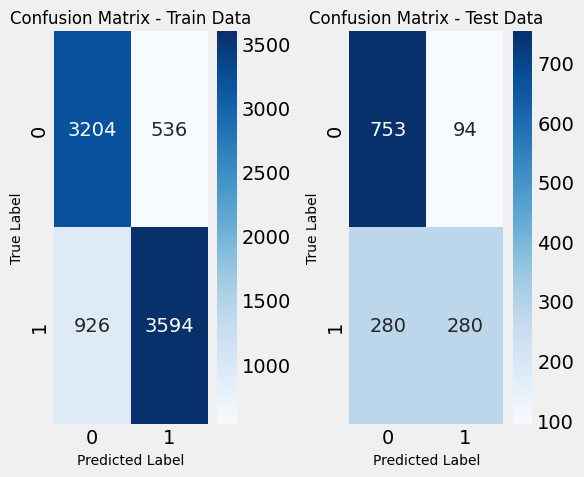

In [35]:
# visulalize the Confusion matrix
cm_train=confusion_matrix(y_train_pred,y_train_smote)
cm_test=confusion_matrix(y_test_pred,y_test)


sns.set_palette('pastel')
plt.figure(figsize=(6,5))
plt.subplot(1,2,1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted Label",fontsize=10)
plt.ylabel("True Label",fontsize=10)
plt.title("Confusion Matrix - Train Data",fontsize=12)
plt.subplot(1,2,2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label",fontsize=10)
plt.title("Confusion Matrix - Test Data",fontsize=12)
plt.tight_layout()
plt.show()

In [36]:
#import pickle
#with open('encoder.pkl','wb') as f:
    #pickle.dump(encoders,f)

#with open('scaler.pkl','wb') as f:
    #pickle.dump(standard,f)

with open("best_model.pkl", "wb") as f:
    pickle.dump(best_models['Random Forest'], f)



In [37]:
with open("best_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)
with open("encoder.pkl", "rb") as f:
    encoders = pickle.load(f)
with open("scaler.pkl", "rb") as f:
    scaler_data =pickle.load(f)

In [38]:
example_input = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 1,
    'PhoneService': 'No',
    'MultipleLines': 'No phone service',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 29.85,
    'TotalCharges': 29.85
}


In [39]:
print(loaded_model.feature_names_in_)


['gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure' 'PhoneService'
 'MultipleLines' 'InternetService' 'OnlineSecurity' 'OnlineBackup'
 'DeviceProtection' 'TechSupport' 'StreamingTV' 'StreamingMovies'
 'Contract' 'PaperlessBilling' 'PaymentMethod' 'MonthlyCharges'
 'TotalCharges']


In [40]:
# Load models, encoders, and scalers
with open("best_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)
with open("encoder.pkl", "rb") as f:
    encoders = pickle.load(f)
with open("scaler.pkl", "rb") as f:
    scaler_data = pickle.load(f)

# Function to preprocess new input data
def preprocess_input(input_data):
    input_df = pd.DataFrame([input_data])
    
    # Apply encoding to categorical features
    for col, encoder in encoders.items():
        if col in input_df.columns:  # Ensure the column exists
            input_df[col] = encoder.transform(input_df[col])

    # Apply scaling to numerical features
    for col, scaler in scaler_data.items():
        if col in input_df.columns:  # Ensure the column exists
            input_df[col] = scaler.transform(input_df[[col]])

    return input_df

# Function to make prediction
def make_prediction(input_data):
    input_df = preprocess_input(input_data)
    
    # Predicting churn and probability using the loaded model
    prediction = loaded_model.predict(input_df)[0]
    probability = loaded_model.predict_proba(input_df)[0, 1]
    
    return "Churn" if prediction == 1 else "No Churn", probability



In [41]:
# Example input data (replace with actual new input data)
example_input = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 1,
    'PhoneService': 'No',
    'MultipleLines': 'No phone service',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 29.85,
    'TotalCharges': 29.85
}

# Get prediction for the example input
prediction, probability = make_prediction(example_input)
print(f"Prediction: {prediction}, Probability: {probability:.2f}")


Prediction: Churn, Probability: 0.70
